# Simple data analysis with Apache Spark
In this example we are going to use Apache Spark to perform distributed analysis on a CSV generated by our Python scrapping class. The goal of this program is mainly to clean data for further analysis down the line.


In [1]:
# Do an initial test of Spark to make sure it works.
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext('local[*]')
# do something to prove it works
rdd = sc.parallelize(range(1000))
rdd.takeSample(False, 5)
sc.stop()

Now that we have checked that PySpark is up and running let's start to do some processing using a csv file generated previously using fb_post.py. For instructions on using fb_scrapper please see the readme file.

In [5]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import regexp_replace, trim, col, lower 
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer

sc = pyspark.SparkContext('local[*]')
sqlContext = SQLContext(sc)
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('160558090672531_facebook_statuses.csv')
df.show()
# Drop the null crap 
df = df.na.drop(subset=["status_message"])
#Remove punctation from status messages
df2 = df.select(regexp_replace("status_message", "\p{Punct}", "").alias("status_message"))
df2.show()
messages = df2.select("status_message")
messages.show()
#Tokenize and remove stop words
tokenizer = Tokenizer(inputCol="status_message", outputCol="filtered")
filterw = tokenizer.transform(messages)
filterw.show()
remover = StopWordsRemover(inputCol="filtered", outputCol="filtered1")
filtered_final = remover.transform(filterw)
filtered_final.show()
messages = filtered_final.select("filtered1")
#Convert to RDD
message_rdd=messages.rdd


+--------------------+--------------------+----------+-----------+--------------------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|           status_id|      status_message| link_name|status_type|         status_link|   status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+--------------------+--------------------+----------+-----------+--------------------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|160558090672531_1...|So, rain is in th...|      null|     status|                null|2016-12-22 13:34:30|            4|          15|         0|        4|        0|       0|        0|       0|         0|
|160558090672531_1...|                null|      null|     status|                null|2016-12-22 21:38:02|           15|           3|         0|       14|        0|       1|      

Now we are going to do a word count with the rdd that we just created. 


The top words are:
boat: 169
anyone: 144
one: 116
get: 93
canoe: 91
im: 91
like: 87
ocoee: 82


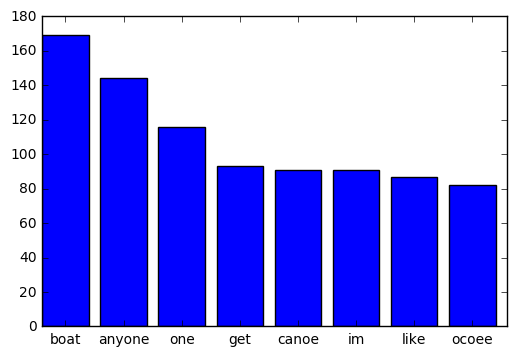

In [55]:
#WordCount with RDD. Normally this would be used in conjunction with NLP to extract trending topics.
from operator import add
import matplotlib.pyplot as plt
import numpy as np
def plot_histogram(indexes, values):
    indexes2 = np.arange(len(indexes))
    values = np.asarray(values)
    plt.bar(indexes2, values)
    bar_width = 2
    plt.xticks(indexes2 + bar_width*.2, indexes)
    plt.show()
    

statuses = message_rdd.flatMap(lambda x: x)
words = statuses.flatMap(lambda x: x)
#se = statuses.flatMap(String)
counts = words.flatMap(lambda x: x.split(' ')) \
                  .map(lambda x: (x, 1)) \
                  .reduceByKey(add)               


output1 = counts.sortByKey().collectAsMap()
#ouput1.saveAsTextFile("keys.txt")
# Get just the most popular words 
output = counts.takeOrdered(9, key = lambda x: -x[1])
indexes = []
values = []
print("The top words are:")
for (word, count) in output:
     if count > 25 and word is not "":
        indexes.append(word)
        values.append(count)
        print("%s: %i" % (word, count))
plot_histogram(indexes,values)

In [ ]:
# Get names of rivers 

We will now be doing some interactive analysis with iPython widgets this will not necessarily render in GitHub, but if you download the notebook you should be able to see it.

In [98]:
# Let's try to make things a little more interactive
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
value_search = widgets.Text() 
display(value_search)

def find_key(sender):
    text = value_search.value
    if text in output1: 
        print(text + " occurs " + str(output1[text]) + " times in the file")
value_search.on_submit(find_key)

drop occurs 13 times in the file


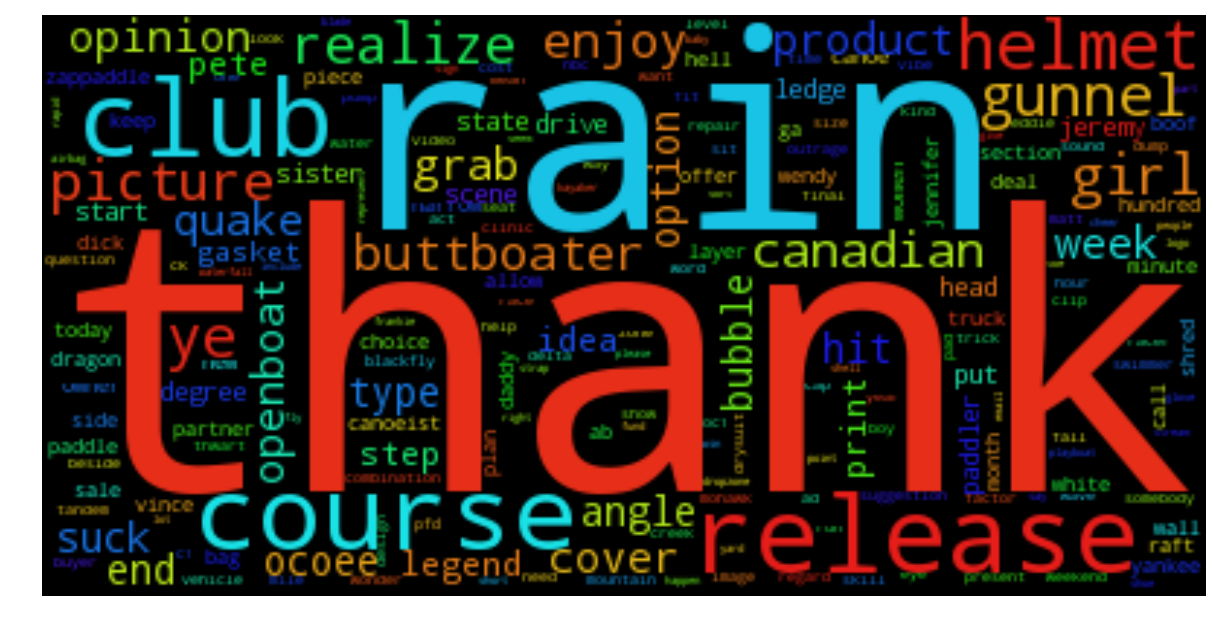

In [96]:
#Wordcloud example 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
wordlist = output1.keys()
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black').generate(" ".join(wordlist))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [6]:
# Filter to extract known names of rivers and get useful URLS 
df2 = df.na.drop(subset=["status_link"])
df3 = df2.select("status_link")
df2.show()

+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|           status_id|      status_message|           link_name|status_type|         status_link|   status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|160558090672531_1...|              Zoomie|                null|      video|https://www.faceb...|2016-12-21 19:12:13|           55|          13|         4|       50|        0|       5|        0|       0|         0|
|160558090672531_1...|Someone don't see...|                null|      video|https://www.faceb...|2016-12-21 17:40:37|           34|         

Okay so now we want to get the images and or videos. Uses for the images might include image search for our database (with the river extracted using NLP) or computer vision applications. 

In [92]:
#Now let's try to use these urls to get their the respective images or videos 
from pyspark.sql import SparkSession
from lxml import html
import requests
from IPython.display import Image
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
df2.createOrReplaceTempView("posts")
sqlDF = spark.sql("SELECT * FROM posts WHERE status_link LIKE '%photo%'")
sqlDF.show()
statusRDD = sqlDF.select('status_link').rdd
urls = statusRDD.flatMap(lambda x: x)
print(urls.take(3))
#Now let's save the images possibly for a Computer Vision application
urls2 = urls.collect()
#for url in urls2:
    #page = requests.get(url)
    #tree = html.fromstring(page.content)
    #imageUrl = tree.xpath('//img[@class="spotlight"]/@src')

+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|           status_id|      status_message|           link_name|status_type|         status_link|   status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+--------------------+--------------------+--------------------+-----------+--------------------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|160558090672531_1...|Doopey, Mr. Magoo...|                null|      photo|https://www.faceb...|2016-12-21 18:35:29|            9|           0|         0|        9|        0|       0|        0|       0|         0|
|160558090672531_1...|we needed more sa...|                null|      photo|https://www.faceb...|2016-12-21 18:25:58|           11|         

In [91]:
# More Natural Language Processing using NLP. Lemmatization, Chunking, and Tagging. 
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
messages = filtered_final.select("filtered")
message_rdd=messages.rdd
message_rdd = message_rdd.flatMap(lambda x:x)
print(message_rdd.first())
pos_statuses = message_rdd.map(nltk.pos_tag)
print(pos_statuses.take(5))
# To do get lemmatization working

['so', 'rain', 'is', 'in', 'the', 'forecast', 'for', 'saturday', 'and', 'saturday', 'night', 'which', 'means', 'we', 'may', 'get', 'some', 'natural', 'flow', 'for', 'christmas', 'would', 'anyone', 'be', 'down', 'to', 'paddle', 'if', 'that', 'happens', 'like', 'little', 'or', 'tellico', 'or', 'something', 'rich', 'holly', 'alex', 'aaaaaaanyone']
[[('so', 'RB'), ('rain', 'NN'), ('is', 'VBZ'), ('in', 'IN'), ('the', 'DT'), ('forecast', 'NN'), ('for', 'IN'), ('saturday', 'JJ'), ('and', 'CC'), ('saturday', 'JJ'), ('night', 'NN'), ('which', 'WDT'), ('means', 'VBZ'), ('we', 'PRP'), ('may', 'MD'), ('get', 'VB'), ('some', 'DT'), ('natural', 'JJ'), ('flow', 'NN'), ('for', 'IN'), ('christmas', 'NN'), ('would', 'MD'), ('anyone', 'NN'), ('be', 'VB'), ('down', 'VBN'), ('to', 'TO'), ('paddle', 'VB'), ('if', 'IN'), ('that', 'DT'), ('happens', 'VBZ'), ('like', 'JJ'), ('little', 'JJ'), ('or', 'CC'), ('tellico', 'NN'), ('or', 'CC'), ('something', 'NN'), ('rich', 'JJ'), ('holly', 'RB'), ('alex', 'VBP'), ('